In [9]:
from IPython.core.display import display, HTML
import pygments
display(HTML("<style>.container { width:290mm !important; }</style>")) # to set cell widths
#to get this into the dissertation, 
#1. widht (above) was changed from 290 to 266 mm 
#2. exported with jupyter notebook as html (space gets wider),
#3. converted to a pdf with https://www.sejda.com/de/html-to-pdf (space gets wider again), 
#4. placed as a Verknüpfung into Adobe illustrator, where for each page separate Zeichenflächen 
#   have been chosen. For their placement the coordinate origin should be changed from "centered" 
#   to "left". 
#5. Each Zeichenfläche was saved separately and loaded in LaTeX
formatter = pygments.formatters.get_formatter_by_name('html', linenos='inline')

In [1]:
import numpy as np
import pandas as pd

#### Calculation: Fiber volume fraction & Relative Density

In [2]:
### Parameters ##########################

# warp fiber radius:
r_wa = 75 #[µm], 
# horizontal distance between surfaces of fiber 1 (left) and fiber 2 (right):
dh_f1s_f2s = np.linspace(0,240,500) #[µm], 
# vertical distance between the ground surface and the surfaces of the lower fiber (here fiber 1):
d_gs_f1s = np.linspace(0,140,int(500*140/200)) #[µm], 
# vertical distance between the lower and higher fiber:
vertical_displ = np.linspace(0,140,3) #[µm]

def calc_fiber_vol_frac(r_wa, dh_f1s_f2s, d_gs_f1s, vertical_displ):
    # fiber 
    fiber_area = 0.5*np.pi * r_wa**2 #[µm²]      
    # horizontal distance between the fiber centers:
    b = dh_f1s_f2s + 2 * r_wa #[µm]    
    # area, in which the fiber volume fraction is calculated
    controll_area = b * (r_wa + d_gs_f1s + vertical_displ/2) #[µm²]  
    # fiber volume fraction:
    fiber_vol_frac = fiber_area / controll_area #[-]
    return fiber_vol_frac   

def calc_rel_density(r_wa, dh_f1s_f2s, d_gs_f1s, vertical_displ):
    # distance between surfaces of ground and higher fiber
    d_gs_f2s = d_gs_f1s + vertical_displ #[µm], 
    # horizontal distance between the the fiber centers
    b = dh_f1s_f2s + 2 * r_wa #[µm], 
    # distance between surfaces of fiber 1 (left) and fiber 2 (right):
    d_f1s_f2s = (b**2 + vertical_displ**2)**0.5 - 2 * r_wa 
    # radius until "CVD surface-to-surface contact" for uniform growth
    r_grown = r_wa + d_f1s_f2s/2 
    # area, in which the relative density is calculated
    controll_area = b * (r_wa + d_gs_f1s + vertical_displ/2) #[µm²]
    
    # part of the radius "h", for which the circle (fiber) overlaps with the ground,    
    h1 = d_f1s_f2s - d_gs_f1s  
    h2 = d_f1s_f2s - d_gs_f2s
    
    def calc_A(h):
        '''
        to calculate the part of the left or right fiber area (A/2) that needs to be removed 
        see https://de.wikipedia.org/wiki/Kreissegment
        '''
        if isinstance(h, int) or isinstance(h, float):
            if h < 0: h = 0
        else: #numpy array:
            h[h < 0] = 0
            
        A = r_grown**2 * np.arccos(1 - h/r_grown) - (r_grown - h) * (2*r_grown*h - h**2)**0.5 
        return A
    
    # solid area = grown fiber area - overlap + grown ground area
    solid_area = np.pi/2 * r_grown**2 - (calc_A(h1) + calc_A(h2))/2 + b*d_f1s_f2s/2 

    rel_density = solid_area / controll_area
    
    return rel_density

#### Contour plots

In [3]:
import matplotlib.pyplot as plt
from   matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from   matplotlib.colors import ListedColormap

In [4]:
def contourPlot(vertical_displ = 0, markers_x = [], markers_y = []):

    fig, ax = plt.subplots(1,1)

    ### Plot labeling and settings #########################
    ax.set_title('$Y^{´}_{\!\!ff}$ = ' + str(vertical_displ) + ' µm', fontsize = 12)
    ax.set_xlabel('$X_{ff}$ [µm]')
    ax.set_ylabel('$Y_{fg}$ [µm]')
    
    # grid and ticks
    ax.grid(alpha = 0.4)
    ax.set_xlim(0, 245)
    ax.set_xticks(np.arange(0, 260, 20).tolist())

    ax.xaxis.set_minor_locator(MultipleLocator(4))    
    ax.yaxis.set_minor_locator(MultipleLocator(4)) 
        
    # rel. density and fiber vol. fraction labels
    ax.text(160, 130 - vertical_displ/2, r'$\rho_{rel}$', color = 'g',
            backgroundcolor = 'w', fontsize = 14)
    ax.text(90, 130 - vertical_displ/2, r'$\Phi_{V_f}$', color = 'b', 
        backgroundcolor = 'w', fontsize = 14)  
    ######################################################## 
    
    # for manual contour label positions:
    def getLabelPosis(x1, x2, y1, y2, n = 6):
        y1b = y1 + 8 - 0.42*vertical_displ
        y2b = y2 + 8 - 0.42*vertical_displ
        m = (y2b - y1b) / (x2 - x1)
        b = y2b - x2*(y2b - y1b) / (x2 - x1)
        f = lambda x: m*x + b

        x = np.linspace(x1, x2, n)
        result = []
        for i in range(n):
            result += [(x[i], f(x[i]))]            
        return result
    # slice contour plot color map   
    def sliceCmap(cmap_name, lo = 0.5, hi = 0.9):
        cmap = plt.cm.get_cmap(cmap_name, 512)
        return ListedColormap(cmap(np.linspace(lo, hi, 256)))
    
    x = dh_f1s_f2s
    y = d_gs_f1s
    X, Y = np.meshgrid(x, y)
    
    # cotour plot for rel. density
    Z = calc_rel_density(r_wa, X, Y, vertical_displ)
    rel_dens_levels=[0.97,0.98,0.99,0.996,0.999,1]        
    CS = plt.contour(X, Y, Z, levels=rel_dens_levels, linewidths = 2, cmap = sliceCmap('Greens'))    
    label_x_pos = 200
    ax.clabel(CS, inline=1, fontsize=11, 
              manual = getLabelPosis(x1 = 205, x2 = 215, y1 = 120, y2 = 25, n = len(rel_dens_levels)))
    
    # cotour plot for fiber vol. fraction
    Z = calc_fiber_vol_frac(r_wa, X, Y, vertical_displ)   
    f_frac_levels = [0.2,0.25,0.30,0.35]  
    CS = plt.contour(X, Y, Z, levels= f_frac_levels, linewidths = 2, cmap = sliceCmap('Blues'))
    label_x_pos = 30
    ax.clabel(CS, inline=1, fontsize=11, 
              manual = getLabelPosis(x1 = 20, x2 = 60, y1 = 60, y2 = 125, n = len(f_frac_levels)))    
        
    # xy marker lines
    marker_colors = ['r', 'orange']
    for i in range(len(markers_x)):                
        ax.plot((0, markers_x[i]),(markers_y[i], markers_y[i]), color = marker_colors[i], zorder = -1)
        ax.plot((markers_x[i], markers_x[i]),(0, markers_y[i]), color = marker_colors[i], zorder = -1)

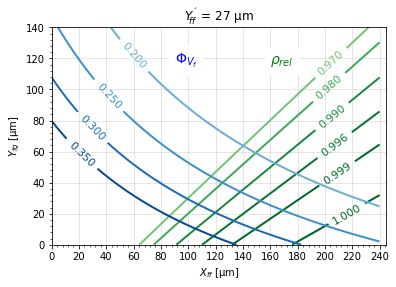

In [5]:
contourPlot(vertical_displ = 27, markers_x = [], markers_y = [])

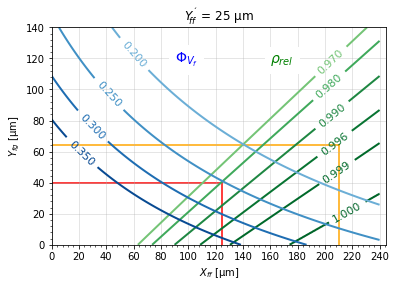

In [6]:
contourPlot(vertical_displ = 25, markers_x = [125,210], markers_y = [40,64])